In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import SRMSE

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','PWGTP','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
pums_data['AGEP'], agep_bins = pd.qcut(pums_data['AGEP'], q=10, labels=False, retbins=True)
pums_data['JWMNP'], jwmnp_bins = pd.qcut(pums_data['JWMNP'], q=10, labels=False, retbins=True)
pums_data['PINCP'], pincp_bins = pd.qcut(pums_data['PINCP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

# Scale by the person-weights to get true population
pums_data = pums_data.reindex(pums_data.index.repeat(pums_data['PWGTP']))
pums_data = pums_data.drop('PWGTP', axis=1)
pums_data_p = pums_data_p.drop('PWGTP', axis=1)
# np.random.seed(420)
pums_data = pums_data.sample(150000)
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
43372,3.0,2,2.0,2,19.0,5,6.0,2.0,2,2.0,1,5.0,5,4.0,2.0,1.0
187700,8.0,6,8.0,2,23.0,1,2.0,2.0,2,2.0,1,7.0,4,5.0,2.0,1.0
349736,6.0,4,7.0,1,15.0,1,1.0,2.0,2,2.0,1,3.0,3,2.0,2.0,1.0
151002,5.0,5,6.0,1,19.0,1,1.0,2.0,2,2.0,1,4.0,4,2.0,2.0,1.0
337793,4.0,3,4.0,1,18.0,5,1.0,2.0,2,2.0,3,1.0,1,1.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170380,7.0,5,9.0,1,16.0,1,4.0,2.0,2,2.0,1,8.0,4,4.0,2.0,1.0
66546,6.0,4,1.0,2,18.0,1,4.0,2.0,2,2.0,1,6.0,4,5.0,2.0,1.0
53809,6.0,7,2.0,1,20.0,3,3.0,2.0,2,2.0,3,2.0,2,4.0,1.0,1.0
233097,4.0,5,4.0,1,17.0,1,1.0,1.0,2,2.0,1,2.0,4,3.0,2.0,1.0


In [3]:
popsim_data_p = pd.read_csv('./populationsim-master/example_wa_16/output/synthetic_persons.csv')[['household_id','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']].dropna()
popsim_data_h = pd.read_csv('./populationsim-master/example_wa_16/output/synthetic_households.csv')[['household_id','HINCP','NP','VEH','BLD','ACCESS']].dropna()
popsim_data = pd.merge(popsim_data_p,popsim_data_h, on='household_id')
popsim_data = popsim_data.drop(labels='household_id', axis=1)

# Convert numerical variables to categorical bins
popsim_data['HINCP'] = pd.cut(popsim_data['HINCP'], bins=hincp_bins, labels=False)
popsim_data['AGEP'] = pd.cut(popsim_data['AGEP'], bins=agep_bins, labels=False)
popsim_data['JWMNP'] = pd.cut(popsim_data['JWMNP'], bins=jwmnp_bins, labels=False)
popsim_data['PINCP'] = pd.cut(popsim_data['PINCP'], bins=pincp_bins, labels=False)

# Remove NA values and check n before/after
print(f"Dataset n={len(popsim_data)} pre-cleaning")
popsim_data = popsim_data.dropna()
print(f"Dataset n={len(popsim_data)} post-cleaning")
popsim_data

Dataset n=3257534 pre-cleaning
Dataset n=3228874 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
0,9,5,1.0,1,16.0,1,1.0,2.0,2,2.0,1,9,5,3.0,2.0,1.0
1,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
2,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
3,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
4,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257529,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0
3257530,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0
3257531,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0
3257532,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0


In [4]:
vae_data = pd.read_csv('./data/synthetic_populations/wa_persons_100000.csv')[['PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P','HINCP','NP','VEH','BLD','ACCESS']].dropna()
vae_data

,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
0,6.0,4,9.0,1,22.0,1,2.0,2.0,2,2.0,1,8.0,5,4.0,2.0,1.0
1,8.0,7,9.0,1,21.0,1,1.0,2.0,2,2.0,9,8.0,5,4.0,2.0,1.0
2,7.0,7,9.0,2,19.0,5,6.0,2.0,2,2.0,1,8.0,5,4.0,2.0,1.0
3,3.0,3,6.0,2,16.0,5,1.0,2.0,2,2.0,1,8.0,5,4.0,2.0,1.0
4,2.0,6,1.0,2,21.0,1,4.0,2.0,2,2.0,1,8.0,5,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247000,8.0,7,6.0,1,21.0,3,7.0,2.0,2,2.0,1,5.0,1,1.0,2.0,1.0
247001,8.0,3,0.0,1,21.0,1,1.0,2.0,2,2.0,1,9.0,2,2.0,1.0,2.0
247002,8.0,4,6.0,1,21.0,1,1.0,2.0,2,2.0,1,9.0,2,2.0,1.0,2.0
247003,7.0,3,0.0,1,21.0,1,1.0,2.0,2,2.0,1,6.0,2,2.0,2.0,1.0


In [5]:
# Time Tests
num_variables = [4,8,16]
time_vae_train_hh = [51,57,63]
time_vae_gen_hh = [52,48,54]
time_vae_train_p = [134,95,120]
time_vae_gen_p = [129,210,449]
time_vae = []
for i in range(len(num_variables)):
    z = time_vae_train_hh[i]+time_vae_gen_hh[i]+time_vae_train_p[i]+time_vae_gen_p[i]
    time_vae.append(z)
time_pop = [245,588,924]
time_vae

[366, 410, 686]

In [6]:
print((924-686)/(924)) # pct improvement

0.25757575757575757


### SRMSE Accuracy Tests

In [7]:
# # SRMSE for the recreated popsim data
print("POPSIM")
srmse_uni_pop = SRMSE.calculateSRMSE(popsim_data.sample(len(pums_data), replace=True), pums_data)
srmse_bi_pop = SRMSE.calculateBivariateSRMSE(popsim_data.sample(len(pums_data), replace=True), pums_data)

POPSIM
Univariate (marginal) SRMSE: 0.3187199543399259, Total Bins: 131
Bivariate (joint) SRMSE: 0.8711478143446335, Total Bins: 7768


In [8]:
# # SRMSE for the recreated cvae data
print("CVAE")
srmse_uni_cvae = SRMSE.calculateSRMSE(vae_data.sample(len(pums_data), replace=True), pums_data)
srmse_bi_cvae = SRMSE.calculateBivariateSRMSE(vae_data.sample(len(pums_data), replace=True), pums_data)

CVAE
Univariate (marginal) SRMSE: 0.295459187334238, Total Bins: 131
Bivariate (joint) SRMSE: 0.8490564039044813, Total Bins: 7768


In [9]:
print((srmse_uni_pop-srmse_uni_cvae)/(srmse_uni_pop)) # pct difference
print((srmse_bi_pop-srmse_bi_cvae)/(srmse_bi_pop)) # pct difference

0.07298183464496702
0.025358969024988704


### SRMSE Sparse Data Test Results

In [10]:
# Data Tests for VAE
num_samples = [100000,10000,1000,100,10,1]
srmse_uni_vae = [.0379,.0341,.0442,.0555,.1289,.2314]
srmse_bi_vae = [.0061,.0058,.0091,.0111,.0200,.0351]

In [11]:
all_pops = []
for num in num_samples:
    pop = pd.read_csv(f"./data/synthetic_populations/wa_persons_{num}.csv")
    pop['num_samples'] = num
    all_pops.append(pop)
all_pops = pd.concat(all_pops)

/home/zack/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


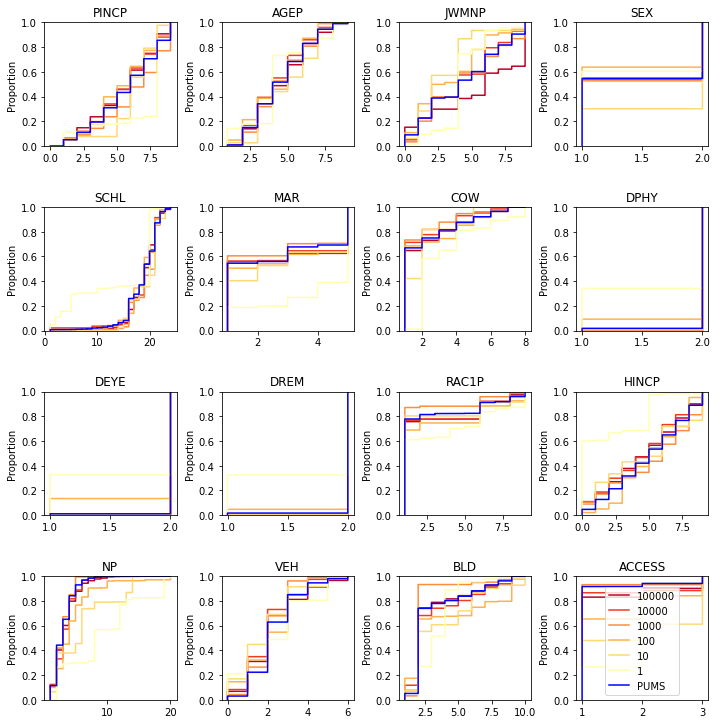

In [12]:
colors = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
colors.reverse()

# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.tight_layout(h_pad=4)

# Plot distribution of each variable for each number of population sample size
for j, popsize in enumerate(num_samples):
    data_subset = all_pops[all_pops['num_samples']==popsize]
    for i, var in enumerate(data_subset.columns[:-1]):
        sns.ecdfplot(data=data_subset, x=var, color=colors[j], ax=axes.flatten()[i])
        axes.flatten()[i].set_title(var)
        axes.flatten()[i].set_xlabel(None)

# Plot the PUMS data distribution on top
for i, var in enumerate(data_subset.columns[:-1]):
    sns.ecdfplot(data=pums_data, x=var, color='blue', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(var)
    axes.flatten()[i].set_xlabel(None)

# Add legend with label for PUMS
plt.legend(labels=num_samples+['PUMS'])

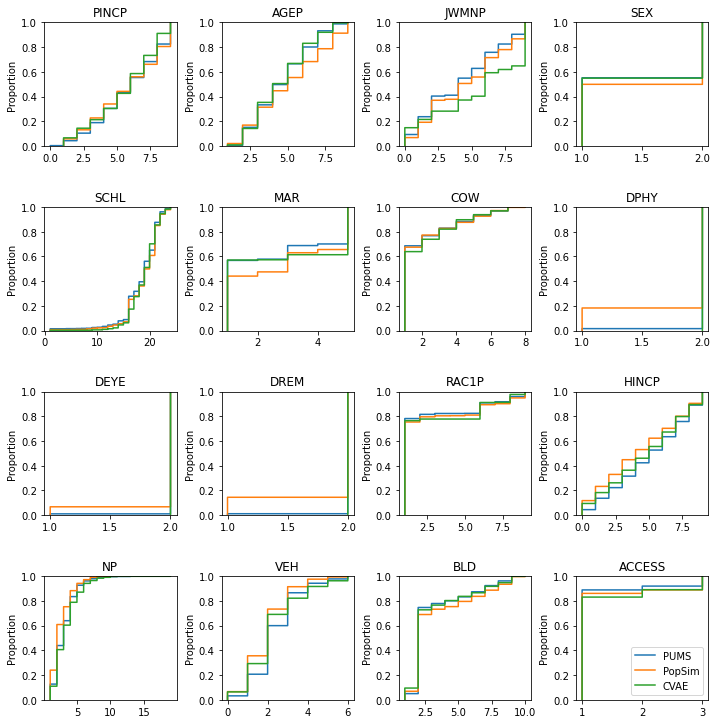

In [13]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(vae_data.columns):
    sns.ecdfplot(data=pums_data.sample(1000), x=var, ax=axes.flatten()[i])
    sns.ecdfplot(data=popsim_data.sample(1000), x=var, ax=axes.flatten()[i])
    sns.ecdfplot(data=vae_data.sample(1000), x=var, ax=axes.flatten()[i])
    axes.flatten()[i].set_title(var)
    axes.flatten()[i].set_xlabel(None)
    plt.legend(labels=['PUMS','PopSim','CVAE'])